In [ ]:
#importing stuff
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import shap
#sns.set(style = "darkgrid")

c:\Users\cnels\Desktop\stat386\Final_Movie_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#loading the dataset
df = pd.read_csv("movie_data.csv")

#getting data summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Title                                212 non-null    object 
 1   Release Date                         150 non-null    object 
 2   Inflation Adjusted Domestic Revenue  188 non-null    float64
 3   Domestic Revenue                     188 non-null    float64
 4   International Revenue                187 non-null    float64
 5   Total Box Office Revenue             187 non-null    float64
 6   Domestic Video Revenue               151 non-null    float64
 7   Opening Weekend                      185 non-null    float64
 8   Production Budget                    148 non-null    float64
 9   Theater Number                       185 non-null    float64
 10  MPAA Rating                          205 non-null    object 
 11  Runtime                         

In [19]:
#Deal with NaN Values
#Using the median to impute most of the values, except for month, which is mode.

#dropping rows without target
df_ml = df.dropna(subset=["Total Box Office Revenue"])
#dropping text columns we can't use
df_ml = df_ml.drop(columns=[
    "Title", "Season", "MPAA Rating", "Genre", "Franchise", "Production Method"
])
#dropping the time-data columns since we have month and year of film release separated
df_ml = df_ml.drop(columns=[
    "Release Date", "Video Release Date"
])
#filling in with median
num_cols = [
    "Inflation Adjusted Domestic Revenue", "Domestic Revenue",
    "International Revenue", "Domestic Video Revenue",
    "Opening Weekend", "Production Budget", "Theater Number",
    "Runtime", "Domestic DVD Revenue", "Domestic Bluray Revenue",
    "Year", "Profit"
]
for col in num_cols:
    df_ml[col] = df_ml[col].fillna(df_ml[col].median())
#filling in month with mode
df_ml["Month"] = df_ml["Month"].fillna(df_ml["Month"].mode()[0])
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 0 to 211
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Inflation Adjusted Domestic Revenue  187 non-null    float64
 1   Domestic Revenue                     187 non-null    float64
 2   International Revenue                187 non-null    float64
 3   Total Box Office Revenue             187 non-null    float64
 4   Domestic Video Revenue               187 non-null    float64
 5   Opening Weekend                      187 non-null    float64
 6   Production Budget                    187 non-null    float64
 7   Theater Number                       187 non-null    float64
 8   Runtime                              187 non-null    float64
 9   Domestic DVD Revenue                 187 non-null    float64
 10  Domestic Bluray Revenue              187 non-null    float64
 11  Month                                

***********************************
Total Box Office Revenue
153733800.0    1
2354875.0      1
86778557.0     1
105632.0       1
57273049.0     1
              ..
77305447.0     1
334560213.0    1
10746915.0     1
756427460.0    1
181805645.0    1
Name: count, Length: 187, dtype: int64


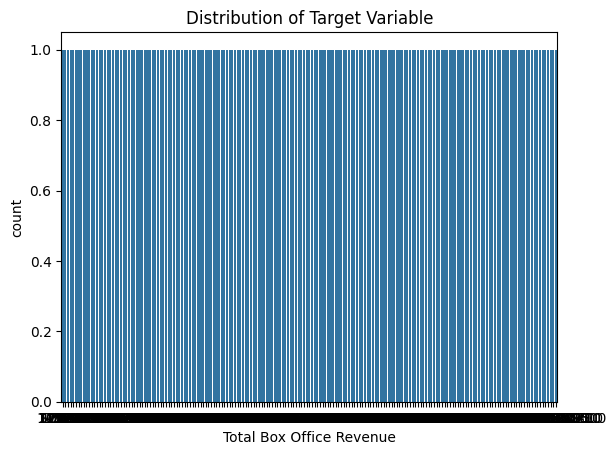

In [ ]:
#Checking some stuff
target_counts = df_ml['Total Box Office Revenue'].value_counts()
print("***********************************")
print(target_counts)

# Plot the distribution of the target variable
sns.countplot(x='Total Box Office Revenue', data=df)
plt.title('Distribution of Target Variable')
plt.show()

In [ ]:
# Log-transform the target due to skewness of target
df_ml["log_revenue"] = np.log1p(df_ml["Total Box Office Revenue"])

y = df_ml["log_revenue"]
X = df_ml[["Inflation Adjusted Domestic Revenue","Domestic Revenue","Domestic Video Revenue","Opening Weekend","Production Budget","Theater Number","Runtime","Domestic DVD Revenue","Domestic Bluray Revenue","Month","Year","Profit"]]


In [41]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#checking shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (149, 12)
Testing data shape: (38, 12)


In [ ]:
#We are going to do three different models and see which one works the best

In [42]:
#Linear Regression Model
# Initialize model
linreg = LinearRegression()

# Train it
linreg.fit(X_train, y_train)

# Predict
y_pred_lin = linreg.predict(X_test)

# Evaluate
print("Linear Regression R²:", r2_score(y_test, y_pred_lin))
print("MAE :", mean_absolute_error(y_test, y_pred_lin))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Linear Regression R²: -0.3168334979009888
MAE : 1.1058389783393414
RMSE : 1.7067429576510176


In [43]:
#Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R²: 0.3470618676269951
MAE: 0.5692441390366527
RMSE: 1.2018179965280806


In [44]:
#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("Gradient Boosting R²:", r2_score(y_test, y_pred_gbr))
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))

Gradient Boosting R²: 0.43041133506746776
MAE: 0.49579688709538744
RMSE: 1.1224922617259352


In [ ]:
#Model I chose: Gradient Booster Regressor
#This is because it had the largest R2, it explained .43 percent of the variance in the data, making it the best predictor out of the three
#However, I just realized that making a predictive model isn't my goal, it's finding predictive features

In [ ]:
#Attempting to find the most important features when predicting
#First getting a Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
#pandas
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False)

Domestic Revenue                       0.548143
Inflation Adjusted Domestic Revenue    0.182221
Profit                                 0.116183
Opening Weekend                        0.041521
Runtime                                0.032703
Month                                  0.030704
Year                                   0.014239
Domestic Video Revenue                 0.010929
Theater Number                         0.006491
Domestic DVD Revenue                   0.006490
Production Budget                      0.005603
Domestic Bluray Revenue                0.004772
dtype: float64

In [ ]:
#using sklearn
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)

perm_importances = pd.Series(perm.importances_mean, index=X.columns)
perm_importances.sort_values(ascending=False)

Domestic Revenue                       0.720972
Inflation Adjusted Domestic Revenue    0.162661
Profit                                 0.142845
Runtime                                0.027408
Month                                  0.021885
Year                                   0.010405
Opening Weekend                        0.010289
Domestic Video Revenue                 0.008577
Domestic DVD Revenue                   0.006548
Production Budget                      0.006026
Theater Number                         0.003767
Domestic Bluray Revenue                0.003472
dtype: float64

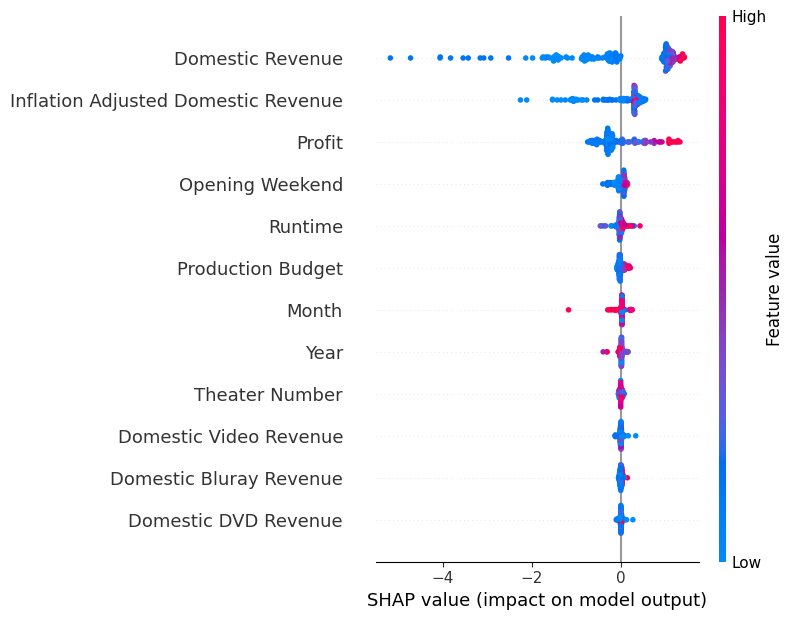

In [52]:
#using shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [58]:
#Trying again, but removing other types of revenue (Now I know that domestic matters the most)
y = df_ml["log_revenue"]
X = df_ml[["Opening Weekend","Production Budget","Theater Number","Runtime","Month","Year"]]

In [59]:
#Doing it again with new labels
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [60]:
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False)

Opening Weekend      0.665007
Theater Number       0.115885
Runtime              0.065854
Month                0.060123
Production Budget    0.054649
Year                 0.038481
dtype: float64

In [61]:
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)
perm_importances.sort_values(ascending=False)

Opening Weekend      1.130070
Theater Number       0.189081
Production Budget    0.069750
Month                0.061801
Runtime              0.056715
Year                 0.036664
dtype: float64

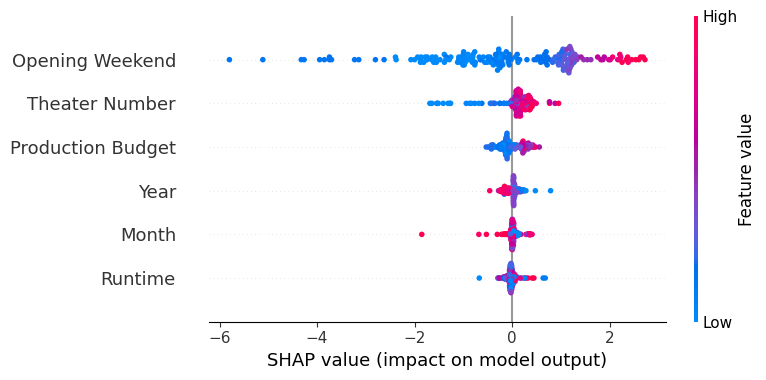

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [67]:
#Now checking it if we don't have the opening weekend, imagine we only have information before it premiers
y = df_ml["log_revenue"]
X = df_ml[["Production Budget","Runtime","Month"]]

In [68]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
print(rf_importances.sort_values(ascending=False))

Production Budget    0.553863
Runtime              0.272461
Month                0.173676
dtype: float64


In [73]:
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)
print(perm_importances.sort_values(ascending=False))

Production Budget    1.357111
Runtime              0.421171
Month                0.307424
dtype: float64


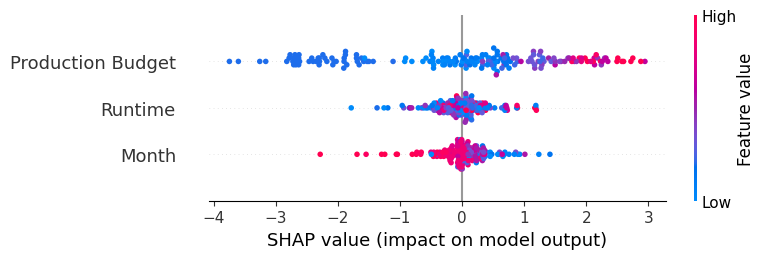

In [71]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
#Conclusions 
#If we have all the information, then the Domestic Revenue matters more than anything else
#If the movie just came out, then the opening weekend amount matters more than anything else
#If the movie asn't released yet, then the production budget is the best indicator. 